# Outlier Detection & Treatment — A Practical Guide

This notebook demonstrates:

- How to detect outliers using visual, statistical, and algorithmic methods  
- How context affects outlier interpretation  
- How to treat outliers using removal, capping, imputation, feature engineering, and robust models  


In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.impute import SimpleImputer
import scipy.stats as stats
from sklearn.preprocessing import PowerTransformer,FunctionTransformer


np.random.seed(42)

# Create normal data
normal_data = np.random.normal(loc=50, scale=5, size=200)

# Add clear outliers
outliers = np.array([20, 100, 120])

# Combine
data = np.concatenate([normal_data, outliers])
df = pd.DataFrame({"value": data})

df.head()

,value
0,52.483571
1,49.308678
2,53.238443
3,57.615149
4,48.829233


In [62]:
# Compute IQR outliers BEFORE plotting anything
Q1 = df["value"].quantile(0.25)
Q3 = df["value"].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df["IQR_outlier"] = (df["value"] < lower) | (df["value"] > upper)

## 1. Visual Detection

Visual methods are the quickest way to spot unusual points:
- Boxplot -> Shows extreme values that fall outside the whiskers. 
- Histogram -> Reveals strange frequency patterns, long tails, or unexpected spikes.
- Scatter Plot-> Highlights isolated points that don’t follow the general trend.
- QQ Plot -> Compares your data to a theoretical normal distribution.Points far from the diagonal line indicate deviations or potential outliers.

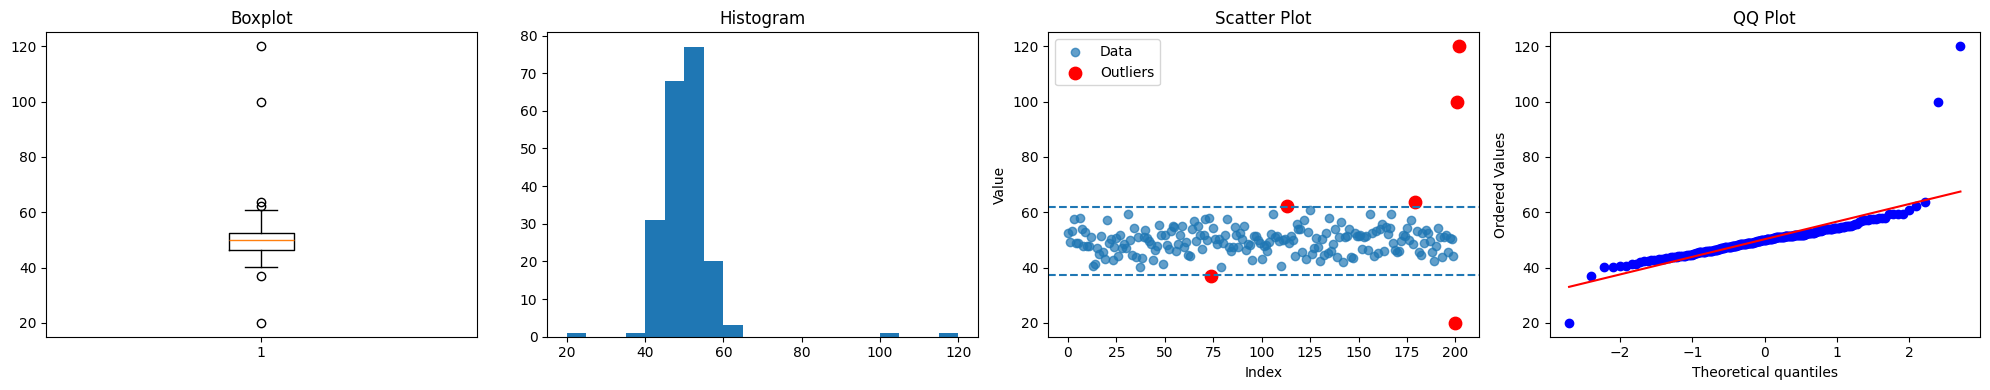

In [63]:
# Visual Detection: Boxplot, Histogram, Scatter Plot, QQ Plot
import scipy.stats as stats

plt.figure(figsize=(20,4))

# Boxplot
plt.subplot(1,4,1)
plt.boxplot(df["value"])
plt.title("Boxplot")

# Histogram
plt.subplot(1,4,2)
plt.hist(df["value"], bins=20)
plt.title("Histogram")

# Scatter Plot (highlighting IQR outliers)
plt.subplot(1,4,3)
plt.scatter(range(len(df)), df["value"], label="Data", alpha=0.7)
plt.scatter(df[df["IQR_outlier"]].index,
            df[df["IQR_outlier"]]["value"],
            color="red", s=80, label="Outliers")
plt.title("Scatter Plot")
plt.xlabel("Index")
plt.ylabel("Value")
plt.axhline(upper, linestyle="--")
plt.axhline(lower, linestyle="--")
plt.legend()

# QQ Plot
plt.subplot(1,4,4)
stats.probplot(df["value"], dist="norm", plot=plt)
plt.title("QQ Plot")

plt.tight_layout()
plt.show()

## 2. Statistical Methods
- IQR  
- Z-score  
- Standard deviation rule  

In [64]:
# IQR Method

df["IQR_outlier"] = (df["value"] < lower) | (df["value"] > upper)
df["IQR_outlier"].value_counts()

IQR_outlier
False    197
True       6
Name: count, dtype: int64

In [65]:
# Z-Score Method

df["z_score"] = (df["value"] - df["value"].mean()) / df["value"].std()
df["Z_outlier"] = df["z_score"].abs() > 3
df["Z_outlier"].value_counts()

Z_outlier
False    200
True       3
Name: count, dtype: int64

In [66]:
# Standard Deviation Rule (3-sigma rule)
mean_val = df["value"].mean()
std_val = df["value"].std()

df["SD_outlier"] = (df["value"] < mean_val - 3 * std_val) | \
                   (df["value"] > mean_val + 3 * std_val)
df["SD_outlier"].value_counts()

SD_outlier
False    200
True       3
Name: count, dtype: int64

## 3. Algorithmic Methods
- Isolation Forest-> isolates rare points quickly
- DBSCAN-> density-based

In [67]:
# Isolation Forest

iso = IsolationForest(contamination=0.02, random_state=42)
df["IF_outlier"] = iso.fit_predict(df[["value"]]) == -1
df["IF_outlier"].value_counts()

IF_outlier
False    198
True       5
Name: count, dtype: int64

In [68]:
#DBSCAN
db = DBSCAN(eps=3, min_samples=5)
df["DBSCAN_label"] = db.fit_predict(df[["value"]])
df["DBSCAN_outlier"] = df["DBSCAN_label"] == -1
df["DBSCAN_outlier"].value_counts()

DBSCAN_outlier
False    199
True       4
Name: count, dtype: int64

In [69]:
# Summary of Outlier Counts
df[[
    "IQR_outlier",
    "Z_outlier",
    "SD_outlier",
    "IF_outlier",
    "DBSCAN_outlier"
]].sum()

IQR_outlier       6
Z_outlier         3
SD_outlier        3
IF_outlier        5
DBSCAN_outlier    4
dtype: int64

## 4. What TO Do With Outliers?

Before acting, ask: Is this an error, a rare event, or the signal itself?
- Removal  (only if clearly wrong)
- Capping (Winsorizing)  
- Imputation  
- Feature engineering  
- Transformation (Reduce Their Influence)

In [70]:
#Removal
df_removed = df[~df["IQR_outlier"]]
df_removed.head()

,value,IQR_outlier,z_score,Z_outlier,SD_outlier,IF_outlier,DBSCAN_label,DBSCAN_outlier
0,52.483571,False,0.283659,False,False,False,0,False
1,49.308678,False,-0.118198,False,False,False,0,False
2,53.238443,False,0.379206,False,False,False,0,False
3,57.615149,False,0.933182,False,False,False,0,False
4,48.829233,False,-0.178883,False,False,False,0,False


In [71]:
#Capping (Winsorizing)
df_capped = df.copy()
df_capped["value"] = np.clip(df_capped["value"], lower, upper)
df_capped.head()

,value,IQR_outlier,z_score,Z_outlier,SD_outlier,IF_outlier,DBSCAN_label,DBSCAN_outlier
0,52.483571,False,0.283659,False,False,False,0,False
1,49.308678,False,-0.118198,False,False,False,0,False
2,53.238443,False,0.379206,False,False,False,0,False
3,57.615149,False,0.933182,False,False,False,0,False
4,48.829233,False,-0.178883,False,False,False,0,False


In [72]:
df_imp = df.copy()

# Mark outliers as NaN
df_imp.loc[df_imp["IQR_outlier"], "value"] = np.nan

# Impute using median
imp = SimpleImputer(strategy="median")
df_imp["value"] = imp.fit_transform(df_imp[["value"]])
df_imp.head()



,value,IQR_outlier,z_score,Z_outlier,SD_outlier,IF_outlier,DBSCAN_label,DBSCAN_outlier
0,52.483571,False,0.283659,False,False,False,0,False
1,49.308678,False,-0.118198,False,False,False,0,False
2,53.238443,False,0.379206,False,False,False,0,False
3,57.615149,False,0.933182,False,False,False,0,False
4,48.829233,False,-0.178883,False,False,False,0,False


In [73]:
#Add an Outlier Flag
df["outlier_flag"] = df["IQR_outlier"].astype(int)
df.head()

,value,IQR_outlier,z_score,Z_outlier,SD_outlier,IF_outlier,DBSCAN_label,DBSCAN_outlier,outlier_flag
0,52.483571,False,0.283659,False,False,False,0,False,0
1,49.308678,False,-0.118198,False,False,False,0,False,0
2,53.238443,False,0.379206,False,False,False,0,False,0
3,57.615149,False,0.933182,False,False,False,0,False,0
4,48.829233,False,-0.178883,False,False,False,0,False,0


In [74]:

df_trans = df.copy()


#Log Transform

df_trans["log_value"] = np.log(df_trans["value"] - df_trans["value"].min() + 1)

# Log1p Transform
log1p_transformer = FunctionTransformer(np.log1p, validate=False)
df_trans["log1p_value"] = log1p_transformer.transform(df_trans[["value"]])

# Square Root Transform
sqrt_transformer = FunctionTransformer(
    lambda x: np.sqrt(x - x.min() + 1),
    validate=False
)
df_trans["sqrt_value"] = sqrt_transformer.transform(df_trans[["value"]])

# Box-Cox Transform
pt_bc = PowerTransformer(method="box-cox")
df_trans["boxcox_value"] = pt_bc.fit_transform(df_trans[["value"]] + 1e-6)

# Yeo-Johnson Transform
pt_yj = PowerTransformer(method="yeo-johnson")
df_trans["yeojohnson_value"] = pt_yj.fit_transform(df_trans[["value"]])

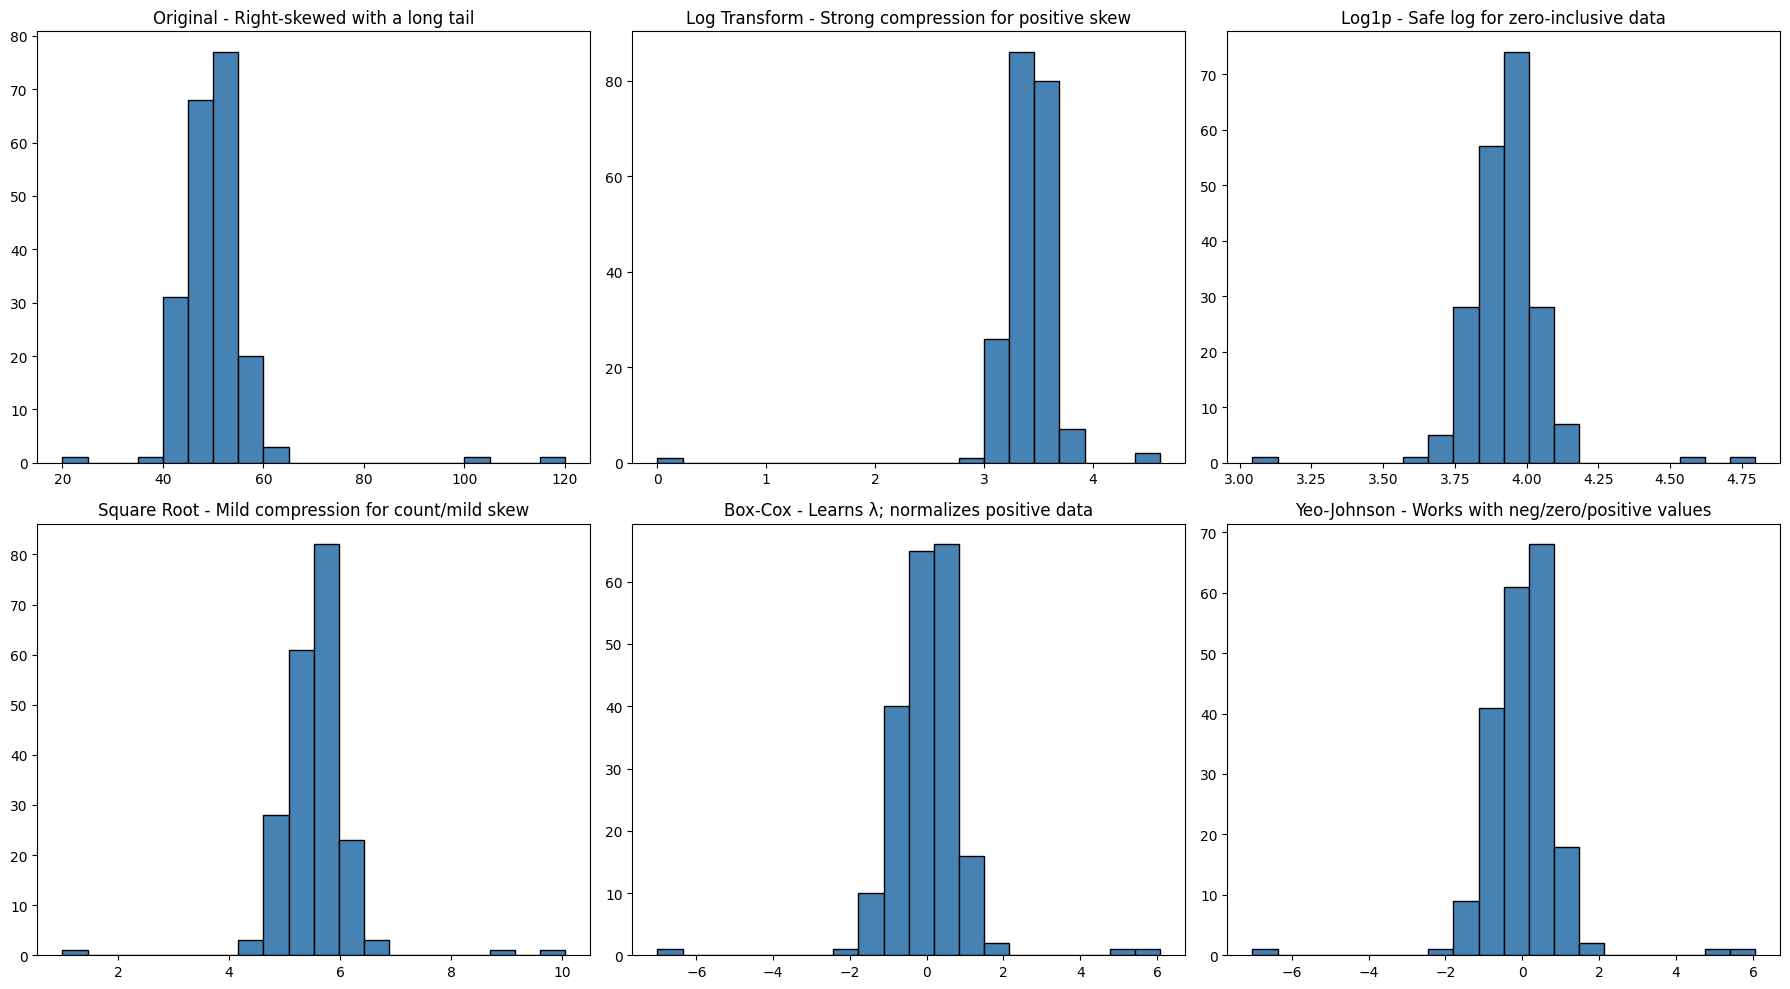

In [75]:
plt.figure(figsize=(18,10))

# Original
plt.subplot(2,3,1)
plt.hist(df_trans["value"], bins=20, color="steelblue", edgecolor="black")
plt.title("Original - Right-skewed with a long tail")

# Log Transform
plt.subplot(2,3,2)
plt.hist(df_trans["log_value"], bins=20, color="steelblue", edgecolor="black")
plt.title("Log Transform - Strong compression for positive skew")

# Log1p Transform
plt.subplot(2,3,3)
plt.hist(df_trans["log1p_value"], bins=20, color="steelblue", edgecolor="black")
plt.title("Log1p - Safe log for zero-inclusive data")

# Square Root
plt.subplot(2,3,4)
plt.hist(df_trans["sqrt_value"], bins=20, color="steelblue", edgecolor="black")
plt.title("Square Root - Mild compression for count/mild skew")

# Box‑Cox automatically learns the best power (λ) to normalize positive‑only data
plt.subplot(2,3,5)
plt.hist(df_trans["boxcox_value"], bins=20, color="steelblue", edgecolor="black")
plt.title("Box-Cox - Learns λ; normalizes positive data")

# Yeo-Johnson
plt.subplot(2,3,6)
plt.hist(df_trans["yeojohnson_value"], bins=20, color="steelblue", edgecolor="black")
plt.title("Yeo-Johnson - Works with neg/zero/positive values")

plt.tight_layout()
plt.show()